In [236]:
using DataFrames, CSV, Plots,Statistics, StatsPlots, Distributions, StatsBase, StatsModels, HypothesisTests, LinearAlgebra, StateSpaceModels, Optim, Plots, GLM

In [237]:
gr(size=(1350,450))

Plots.GRBackend()

In [238]:
cd("/Users/ning/Documents/Working_Directory/Tex_MD/Teaching/tutorial/6003/W7")

In [239]:
df = CSV.read("ausunemp.csv", DataFrame);
select!(df, Not(:month));

In [240]:
df1 = DataFrame(unemp = repeat([missing;], 30));
df  = vcat(df, df1);

last(df,5)

,unemp
,Float64?
1,missing
2,missing
3,missing
4,missing
5,missing


In [241]:
df[:,:t]  = [1:size(df)[1];];
df[:,:t2] = df.t.^2;
df[:,:t3] = df.t.^3;
df[:,:t4] = df.t.^4;
df[:,:t5] = df.t.^5;

In [242]:
month = repeat([1:12;], convert(Int64, ceil(size(df)[1]/12)));

df[:,:month] = month[1:size(df)[1]];

In [243]:
last(df, 5)

,unemp,t,t2,t3,t4,t5,month
,Float64?,Int64,Int64,Int64,Int64,Int64,Int64
1,missing,381,145161,55306341,21071715921,8028323765901,9
2,missing,382,145924,55742968,21293813776,8134236862432,10
3,missing,383,146689,56181887,21517662721,8241264822143,11
4,missing,384,147456,56623104,21743271936,8349416423424,12
5,missing,385,148225,57066625,21970650625,8458700490625,1


# line-plot of Y to determine whether an additive or a multiplicative decomposition appears to make the most sense

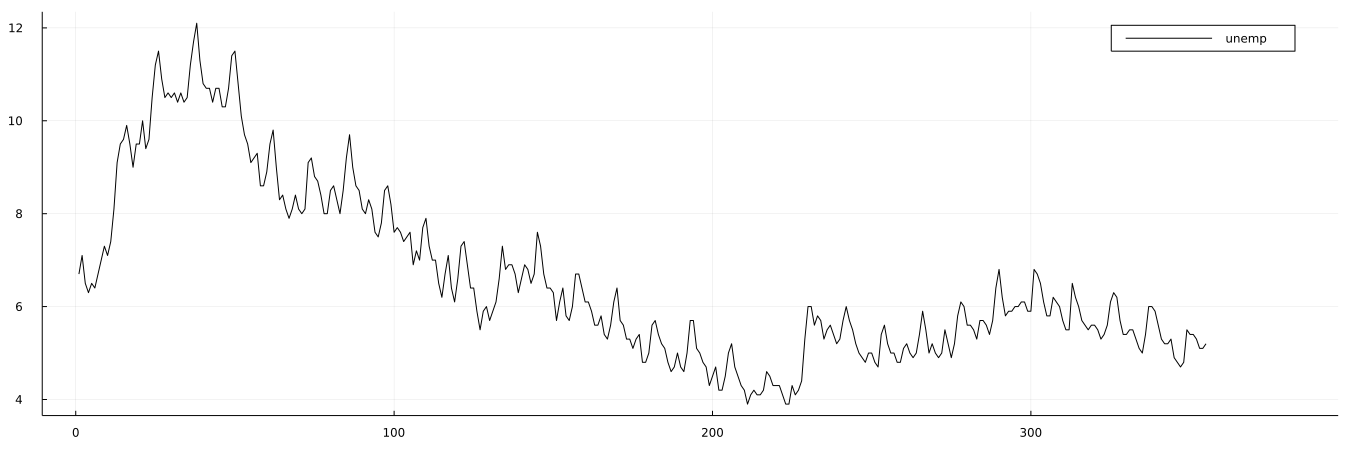

In [244]:
plot(xlabel="t", legend=:topright)
plot!(df.t, df.unemp, color="black", label="unemp")

# Now let's remove noise. Firstly, let's compute $\mathrm{MA}_t$ to average out the noise

In [245]:
df[:,:ma] = (lag(df[:,:unemp], 6) + lag(df[:,:unemp], 5) + lag(df[:,:unemp], 4) + lag(df[:,:unemp], 3) + lag(df[:,:unemp], 2) + lag(df[:,:unemp], 1) + df[:,:unemp] + lead(df[:,:unemp], 1) + lead(df[:,:unemp], 2) + lead(df[:,:unemp], 3) + lead(df[:,:unemp], 4) + lead(df[:,:unemp], 5)) / 12;

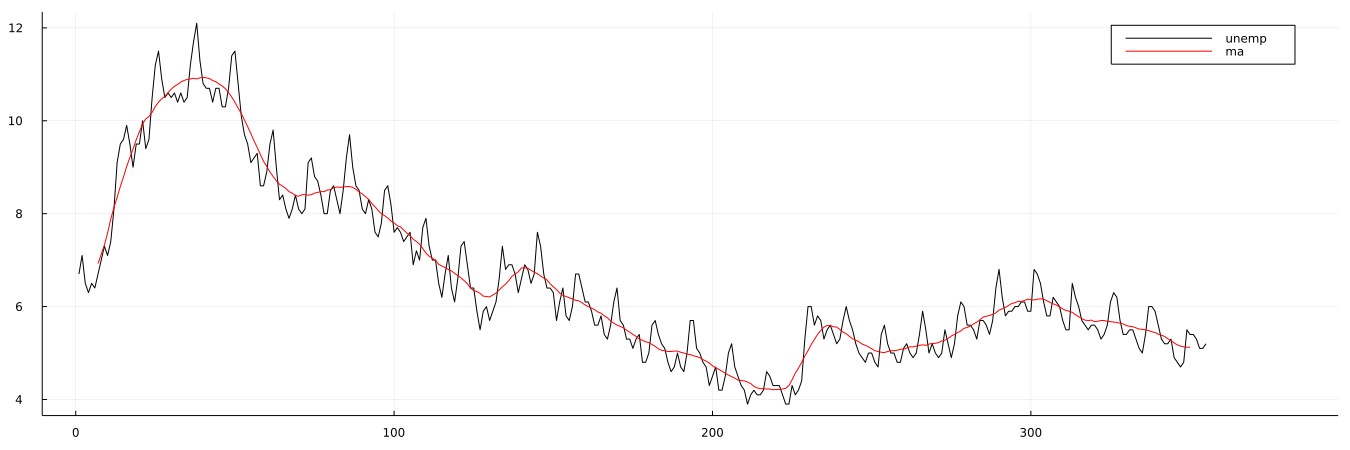

In [246]:
plot(xlabel="t", legend=:topright)
plot!(df.t, df.unemp, color="black", label="unemp")
plot!(df.t, df.ma   , color="red"  , label="ma"   )

# compute $\mathrm{CMA}_t$

In [247]:
df[:,:cma] = (df[:,:ma] + lead(df[:,:ma],1)) / 2;

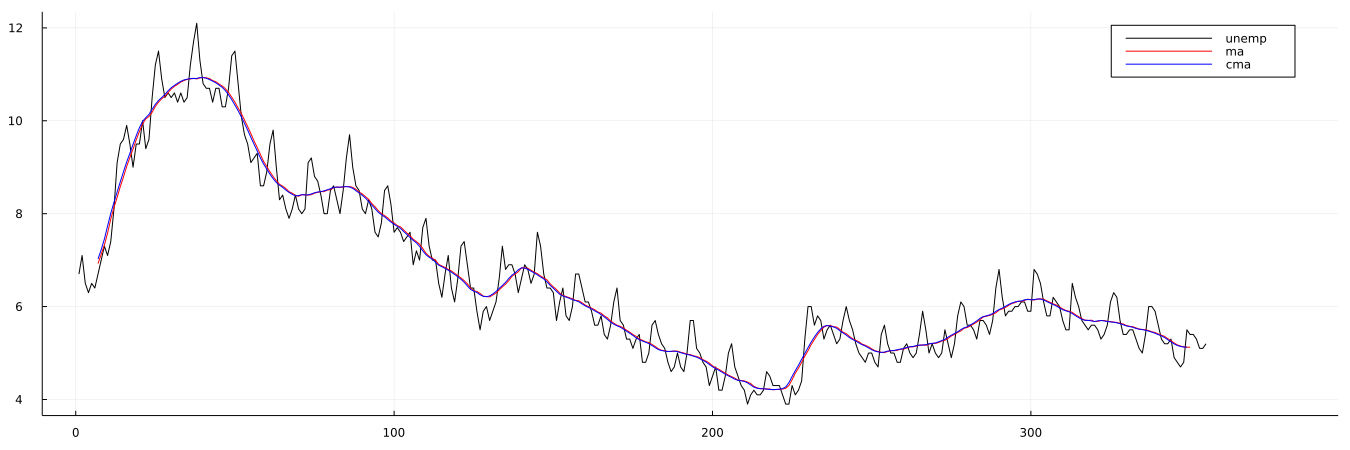

In [248]:
plot(xlabel="t", legend=:topright)
plot!(df.t, df.unemp, color="black", label="unemp")
plot!(df.t, df.ma   , color="red"  , label="ma"   )
plot!(df.t, df.cma  , color="blue" , label="cma"  )

# compute $\frac{Y_t}{\mathrm{CMA}_t}$

In [249]:
df[:,:y_over_cma] = df[:,:unemp] ./ df[:,:cma];

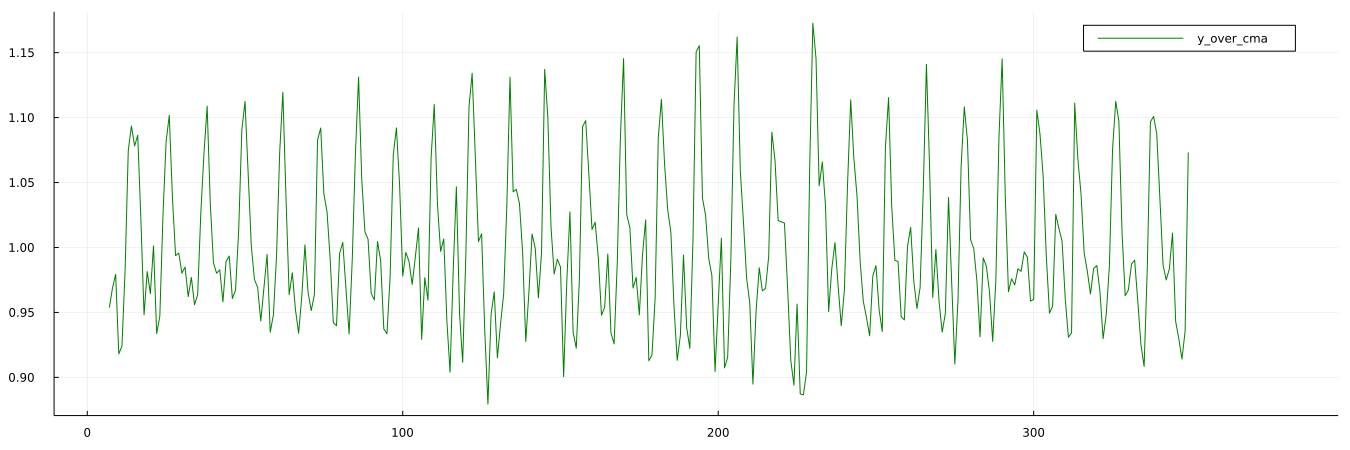

In [250]:
plot(xlabel="t", legend=:topright)
plot!(df.t, df.y_over_cma  , color="green" , label="y_over_cma")

# after removing noise from unemp (which returns $\frac{Y_t}{\mathrm{CMA}_t}$), let's extract $\mathrm{SN}_t$ for $\frac{Y_t}{\mathrm{CMA}_t}$

In [251]:
ux = unique(df.month);

dummy = select(df, :month .=> [ByRow(v -> x in v) for x in ux] .=> Symbol.(ux))

colnames = ["m1", "m2", "m3", "m4", "m5", "m6", "m7", "m8", "m9", "m10", "m11", "m12"];
rename!(dummy, Symbol.(colnames)); 

df = hcat(df, dummy);

describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,Type
1,unemp,6.6062,3.9,6.0,12.1,30,"Union{Missing, Float64}"
2,t,193.0,1,193.0,385,0,Int64
3,t2,49601.0,1,37249.0,148225,0,Int64
4,t3,1.43409e7,1,7.18906e6,57066625,0,Int64
5,t4,4.42271e9,1,1.38749e9,21970650625,0,Int64
6,t5,1.42079e12,1,2.67785e11,8458700490625,0,Int64
7,month,6.48571,1,6.0,12,0,Int64
8,ma,6.6274,4.20833,5.9875,10.9333,41,"Union{Missing, Float64}"
9,cma,6.62915,4.2125,5.98333,10.9292,42,"Union{Missing, Float64}"


In [252]:
fm_SN = @formula(y_over_cma ~ 0 + m1 + m2 + m3 + m4 + m5 + m6 + m7 + m8 + m9 + m10 + m11 + m12)
OLS_SN = lm(fm_SN, df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y_over_cma ~ 0 + m1 + m2 + m3 + m4 + m5 + m6 + m7 + m8 + m9 + m10 + m11 + m12

Coefficients:
─────────────────────────────────────────────────────────────────
        Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────
m1   1.08348   0.00484801  223.49    <1e-99   1.07394    1.09301
m2   1.11547   0.00493382  226.09    <1e-99   1.10576    1.12517
m3   1.05448   0.00493382  213.72    <1e-99   1.04477    1.06418
m4   1.00887   0.00493382  204.48    <1e-99   0.999162   1.01857
m5   0.995486  0.00493382  201.77    <1e-99   0.98578    1.00519
m6   0.968487  0.00493382  196.30    <1e-99   0.958781   0.978193
m7   0.945879  0.00484801  195.11    <1e-99   0.936342   0.955416
m8   0.972493  0.00484801  200.60    <1e-99   0.962956   0.98203
m9   0.995027  0.004848

In [253]:
df[:,:snbar] = predict(OLS_SN, df);

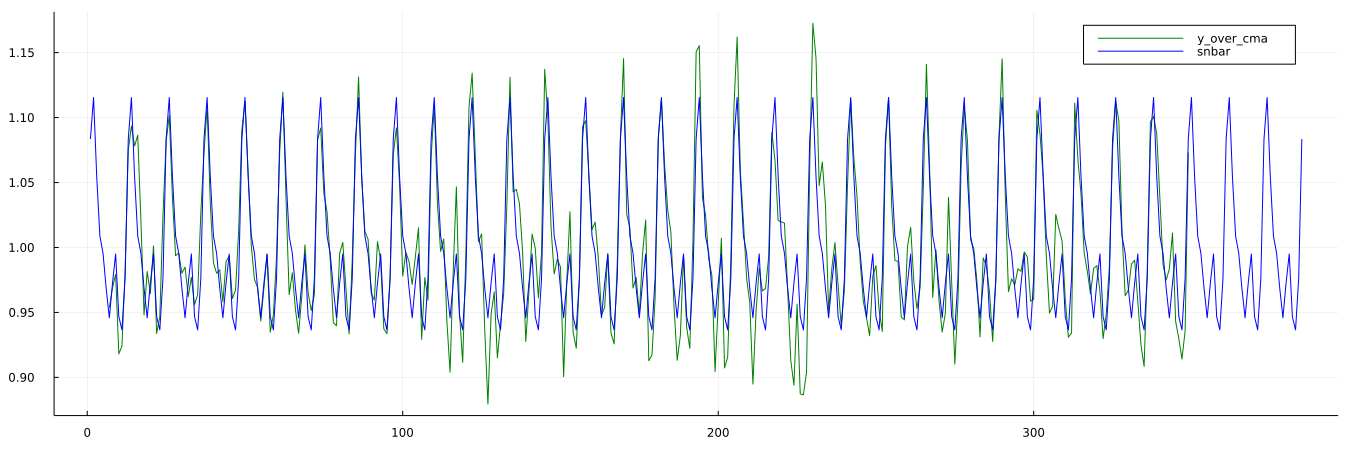

In [254]:
plot(xlabel="t", legend=:topright)
plot!(df.t, df.y_over_cma, color="green", label="y_over_cma")
plot!(df.t, df.snbar     , color="blue", label="snbar")

# careful: the regression trick that we used during the lecture to find the mean of the snbar doesn't work here, because there are more Januaries-Julies than Augusts-Decembers in this data set. We can fix that by only regressing over the first year (or any year, really... or any period that includes equally many observations for each month)

In [255]:
snbarconst = mean(df[:,:snbar][1:12]);

In [256]:
df[:,:sn] = df[:,:snbar] ./ snbarconst;

# the deseasonalised data seem to broadly follow an up-down-up-down pattern, so a polynomial could be a sensible trend specification

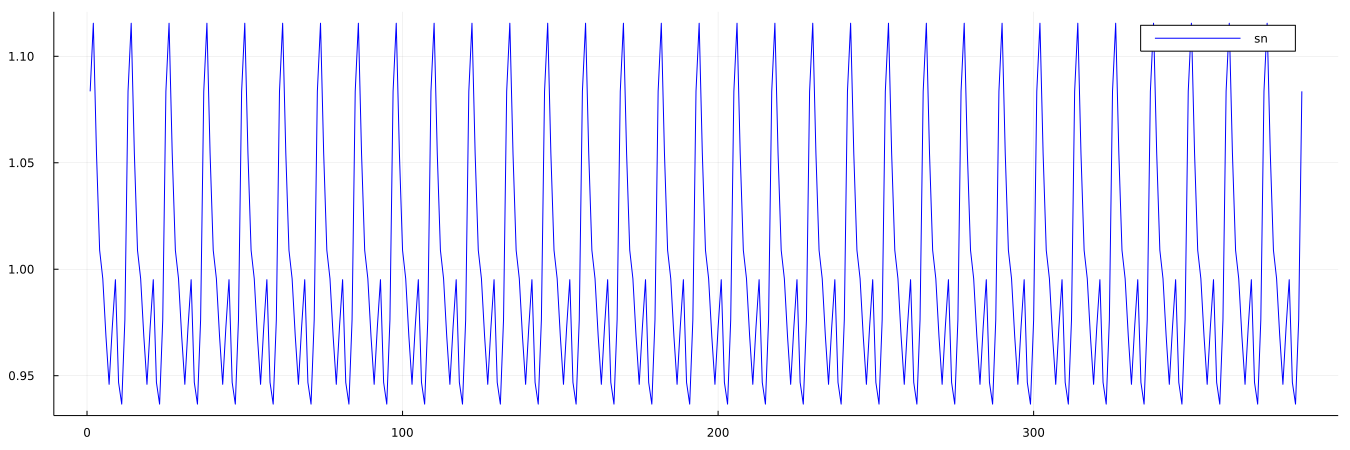

In [257]:
plot(xlabel="t", legend=:topright)
plot!(df.t, df.sn, color="blue", label="sn")

# now let's remove $SN_t$ from unemp and generate $d_t$

In [258]:
df[:,:d] = df[:,:unemp] ./ df[:,:sn];

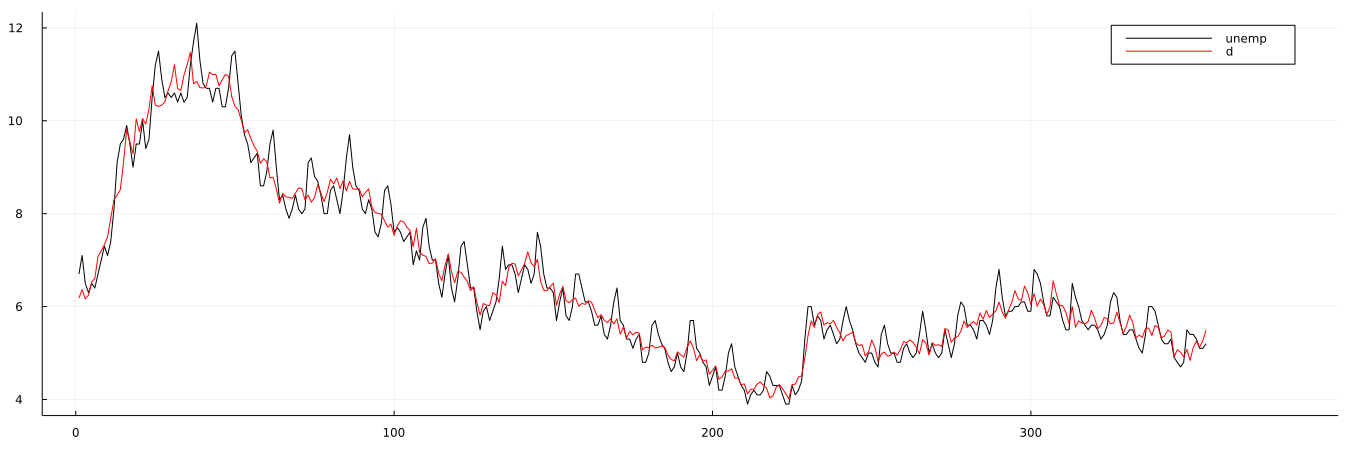

In [259]:
plot(xlabel="t", legend=:topright)
plot!(df.t, df.unemp, color="black", label="unemp")
plot!(df.t, df.d    , color="red"  , label="d"    )

# now let's use polynomial of time to extract the trend component

In [260]:
fm_tr = @formula(d ~ 1 + t + t2 + t3 + t4)
OLS_tr = lm(fm_tr, df, dropcollinear=false)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

d ~ 1 + t + t2 + t3 + t4

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error       t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)   7.59624     0.159517      47.62    <1e-99   7.28251      7.90998
t             0.108053    0.00619023    17.46    <1e-48   0.0958786    0.120228
t2           -0.00163151  7.05699e-5   -23.12    <1e-71  -0.0017703   -0.00149271
t3            6.94103e-6  2.97641e-7    23.32    <1e-72   6.35564e-6   7.52642e-6
t4           -9.21282e-9  4.14775e-10  -22.21    <1e-68  -1.00286e-8  -8.39705e-9
─────────────────────────────────────────────────────────────────────────────────

In [261]:
df[:,:tr] = predict(OLS_tr, df);

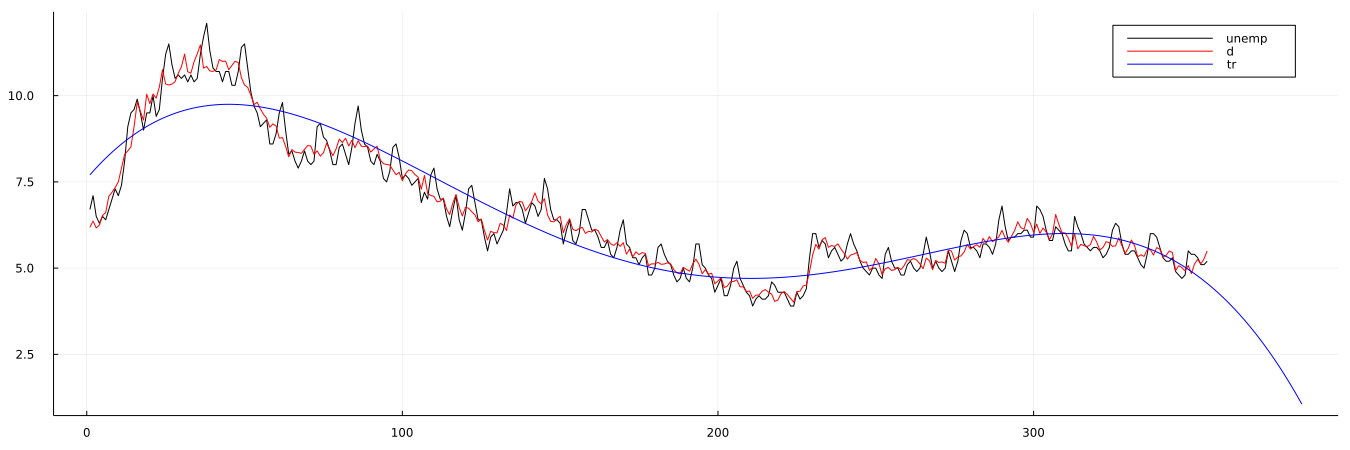

In [262]:
plot(xlabel="t", legend=:topright)
plot!(df.t, df.unemp, color="black", label="unemp")
plot!(df.t, df.d    , color="red"  , label="d"    )
plot!(df.t, df.tr   , color="blue" , label="tr"    )

# looks decent. not perfectly fitting the early 1990s unemployment peak, but maybe we can attribute the difference to a cyclical swing. we could add yet another power to that polynomial... but four is already feeling uncomfortably large

# Now let's compute $TR_t \cdot SN_t$

In [263]:
df[:,:trsn] = df[:,:tr] .* df[:,:sn];

In [264]:
pred_trsn = predict(OLS_tr, df, interval = :prediction, level = 0.95)

df[:,:trsn_lo]=pred_trsn[:,:lower];
df[:,:trsn_hi]=pred_trsn[:,:upper];

In [265]:
df[:,:clir] = df[:,:d] ./ df[:,:tr];
df[:,:cl]   = (lag(df[:,:clir], 1) + df[:,:clir] + lead(df[:,:clir], 1))/3;

df[:,:cl][1]      = (2 * df[:,:clir][1] + df[:,:clir][2])/3;
df[:,:cl][355]    = (2 * df[:,:clir][355] + df[:,:clir][354])/3;
df[:,:cl][loc_na] .= 1;

df[:,:ir    ] = df[:,:clir] ./ df[:,:cl];
df[:,:trsncl] = df[:,:trsn] .* df[:,:cl];

# now let's plot everything and check if it works

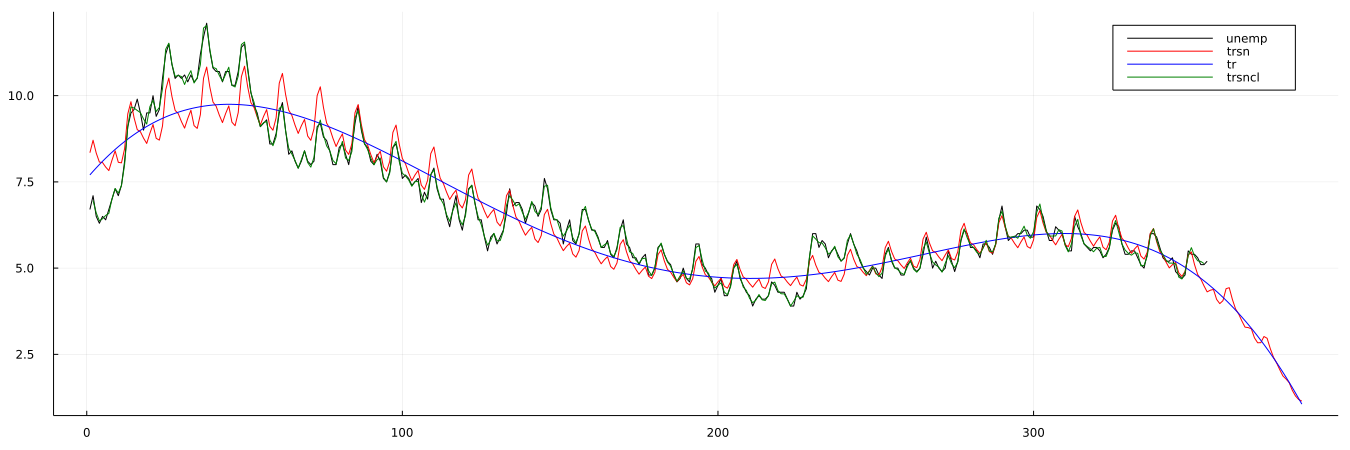

In [266]:
plot(xlabel="t", legend=:topright)
plot!(df.t, df.unemp , color="black", label="unemp" )
plot!(df.t, df.trsn  , color="red"  , label="trsn"  )
plot!(df.t, df.tr    , color="blue" , label="tr"    )
plot!(df.t, df.trsncl, color="green", label="trsncl")

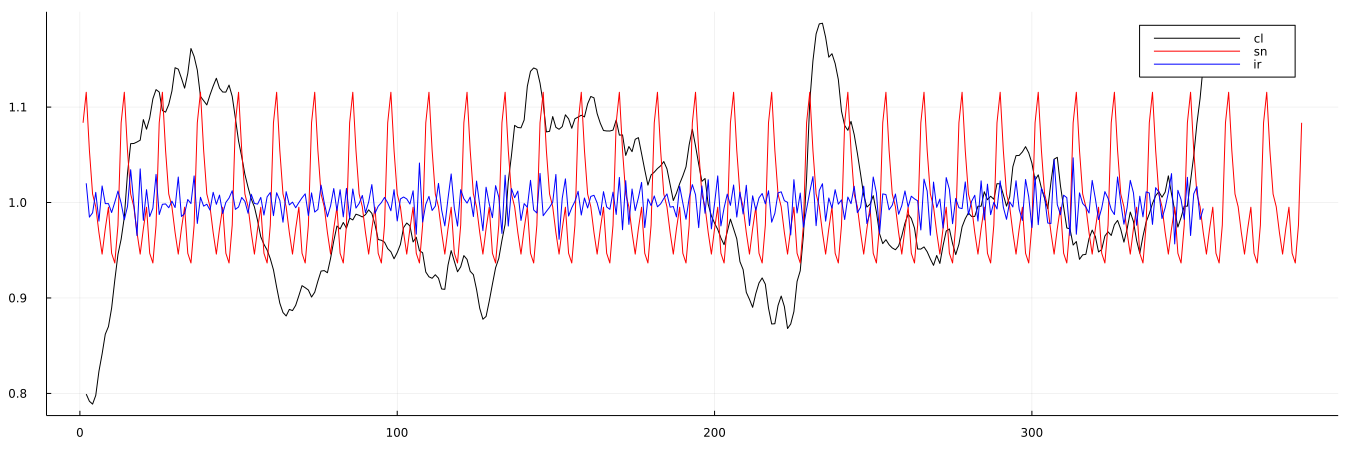

In [267]:
plot(xlabel="t", legend=:topright)
plot!(df.t, df.cl, color="black", label="cl")
plot!(df.t, df.sn, color="red"  , label="sn")
plot!(df.t, df.ir, color="blue" , label="ir")

# everything looks pretty reasonable. Let's plot the prediction interval

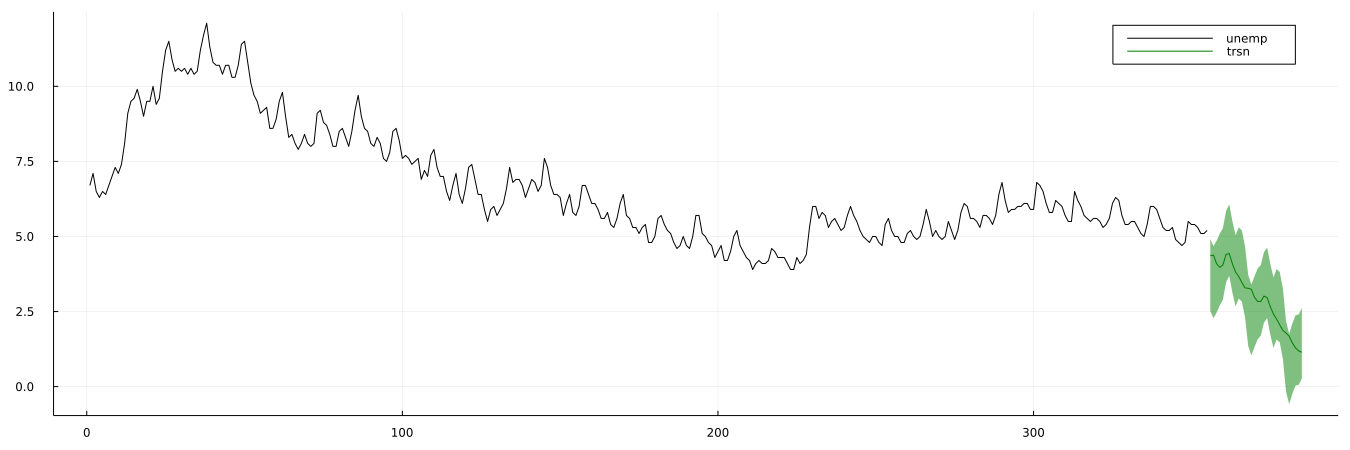

In [269]:
plot(xlabel="t", legend=:topright)
plot!(df.t, df.unemp, color="black", label="unemp" )
plot!(df.t[356:end], df.trsn[356:end], color="green", label="trsn ", ribbon = (df.trsn .- df.trsn_lo, df.trsn_hi .- df.trsn))

In [270]:
run(`rm -rf W6_Julia.html`)
run(`jupyter nbconvert --to html W6_Julia.ipynb`)

[NbConvertApp] Converting notebook W6_Julia.ipynb to html
[NbConvertApp] Writing 1038445 bytes to W6_Julia.html


Process(`jupyter nbconvert --to html W6_Julia.ipynb`, ProcessExited(0))